

# Loan Default Probability 

The goal of this case study is to build a machine learning model to predict the probability that a loan will default.

## Content

* [1. Problem Definition](#0)
* [2. Getting Started - Load Libraries and Dataset](#1)
    * [2.1. Load Libraries](#1.1)    
    * [2.2. Load Dataset](#1.2)
* [3. Data Preparation and Feature Selection](#2)
    * [3.1. Preparing the predicted variable](#2.1)    
    * [3.2. Feature Selection-Limit the Feature Space](#2.2)
        * [3.2.1.  Features elimination by significant missing values ](#2.2.1)
        * [3.2.2.  Features elimination based on the intutiveness](#2.2.2)
        * [3.2.3.  Features elimination based on the correlation](#2.2.3)   
* [4. Feature Engineering and Exploratory Analysis](#3)
    * [4.1 Feature Analysis and Exploration](#3.1)
        * [4.1.1. Analysing the categorical features](#3.1.1)
        * [4.1.2  Analysing the continuous features ](#3.1.2) 
    * [4.2.Encoding Categorical Data](#3.2)
    * [4.3.Sampling Data](#3.3)    
* [5.Evaluate Algorithms and Models](#4)        
    * [5.1. Train/Test Split](#4.1)
    * [5.2. Test Options and Evaluation Metrics](#4.2)
    * [5.3. Compare Models and Algorithms](#4.3)
* [6. Model Tuning and Grid Search](#5)  
* [7. Finalize the Model](#6)  
    * [7.1. Results on test dataset](#6.1)
    * [7.1. Variable Intuition/Feature Selection](#6.2) 
    * [7.3. Save model for later use](#6.3)


<a id='0'></a>
# 1. Problem Definition

The problem is defined in the classification framework, where the predicted variable
is “Charge-Off ”. A charge-off is a debt that a creditor has given up trying to collect on
after you’ve missed payments for several months. The predicted variable takes value 1
in case of charge-off and 0 otherwise.

This case study aims to analyze data for loans through 2007-2017Q3 from Lending Club available on Kaggle. Dataset contains over 887 thousand observations and 150 variables among which one is describing the loan status. 

<a id='1'></a>
# 2. Getting Started- Loading the data and python packages

<a id='1.1'></a>
## 2.1. Loading the python packages

In [1]:
# Core libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import SGD

# Libraries for Saving the Model
from pickle import dump, load


2022-09-13 10:19:55.759401: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-13 10:19:55.759445: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


<a id='1.2'></a>
## 2.2. Loading the Data

We load the data in this step.

#### <font color='red'>Note : Due to limit in the github for the data size, a sample of the data has been loaded in the jupyter notebook repository of this book. However, all the subsequent results in this jupyter notebook is with actual data (~1GB) under https://www.kaggle.com/mlfinancebook/lending-club-loans-data. You should load the full data in case you want to reproduce the results. </font> 

In [2]:
# Load dataset

# loans = pd.read_csv('LoansData.csv.gz', compression='gzip', low_memory=True) # Use this for the actual data
loans = pd.read_csv('LoansData_sample.csv.gz', compression='gzip', encoding='utf-8')


/home/william/github/will-i-amv-books/ml-and-ds-blueprints-for-finance/env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3398: DtypeWarning: Columns (19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
dataset = loans

In [4]:
# Disable the warnings
import warnings
warnings.filterwarnings('ignore')


In [5]:
type(dataset)


pandas.core.frame.DataFrame

<a id='2'></a>
## 3. Data Preparation and Feature Selection

<a id='2.1'></a>
## 3.1. Preparing the predicted variable


In [6]:
# We'll try to predict the loan_status variable. 

dataset['loan_status'].value_counts(dropna=False) # Value counts for this variable


Fully Paid            69982
Charged Off           16156
Current               12726
Late (31-120 days)      730
In Grace Period         264
Late (16-30 days)       139
Default                   3
Name: loan_status, dtype: int64

We're going to try to learn differences in the features between completed loans that have been fully paid or charged off. We won't consider loans that are current, don't meet the credit policy, defaulted, or have a missing status. So we only keep the loans with status "Fully Paid" or "Charged Off."

In [7]:
dataset = dataset.loc[dataset['loan_status'].isin(['Fully Paid', 'Charged Off']), :]
dataset['loan_status'].value_counts(dropna=False)


Fully Paid     69982
Charged Off    16156
Name: loan_status, dtype: int64

In [8]:
dataset['loan_status'].value_counts(normalize=True, dropna=False)


Fully Paid     0.812441
Charged Off    0.187559
Name: loan_status, dtype: float64

About 80% of the remaining loans have been fully paid and 20% have charged off, so we have a somewhat unbalanced classification problem.

In [9]:
dataset['charged_off'] = (dataset['loan_status'] == 'Charged Off').apply(np.uint8)
dataset.drop('loan_status', axis=1, inplace=True)


<a id='2.2'></a>
## 3.2. Feature Selection-Limit the Feature Space 

The full dataset has 150 features for each
loan. We’ll eliminate
features in following steps using three different approaches:
* Eliminate feature that have more than 30% missing values.
* Eliminate features that are unintuitive based on subjective judgement.
* Eliminate features with low correlation with the predicted variable

<a id='2.2.1'></a>
### 3.2.1.  Features elimination by significant missing values

First calculating the percentage of missing data for each feature:

In [10]:
missing_fractions = dataset.isnull().mean().sort_values(ascending=False)
missing_fractions.head(10)


total_cu_tl                            1.0
annual_inc_joint                       1.0
sec_app_mths_since_last_major_derog    1.0
sec_app_collections_12_mths_ex_med     1.0
sec_app_chargeoff_within_12_mths       1.0
open_rv_12m                            1.0
sec_app_num_rev_accts                  1.0
sec_app_open_act_il                    1.0
sec_app_revol_util                     1.0
sec_app_open_acc                       1.0
dtype: float64

In [11]:
drop_list = sorted(list(missing_fractions[missing_fractions > 0.3].index))


In [12]:
len(drop_list)

58

In [13]:
dataset.drop(labels=drop_list, axis=1, inplace=True)
dataset.shape

(86138, 93)

<a id='2.2.2'></a>
### 3.2.2.  Features elimination based on the intutiveness

In order to filter the features further we check the description in the data dictionary and keep the features that are
intuitive on the basis of subjective judgement. 

We examine the LendingClub website and Data Dictionary to determine which features would have been available to potential investors. Here's the list of features we currently have, in alphabetical order:

In [14]:
print(sorted(dataset.columns))

['Unnamed: 0', 'acc_now_delinq', 'acc_open_past_24mths', 'addr_state', 'annual_inc', 'application_type', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'charged_off', 'chargeoff_within_12_mths', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'debt_settlement_flag', 'delinq_2yrs', 'delinq_amnt', 'disbursement_method', 'dti', 'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 'funded_amnt', 'funded_amnt_inv', 'grade', 'hardship_flag', 'home_ownership', 'id', 'initial_list_status', 'inq_last_6mths', 'installment', 'int_rate', 'issue_d', 'last_credit_pull_d', 'last_fico_range_high', 'last_fico_range_low', 'last_pymnt_amnt', 'last_pymnt_d', 'loan_amnt', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_

The list that is kept is as follows: 

In [15]:
keep_list = [
    'charged_off', 'funded_amnt', 'addr_state', 'annual_inc', 'application_type', 'dti', 
    'earliest_cr_line', 'emp_length', 'emp_title', 'fico_range_high', 'fico_range_low', 
    'grade', 'home_ownership', 'id', 'initial_list_status', 'installment', 'int_rate', 
    'loan_amnt', 'loan_status', 'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 
    'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 'title', 'total_acc', 
    'verification_status', 'zip_code', 'last_pymnt_amnt', 'num_actv_rev_tl', 'mo_sin_rcnt_rev_tl_op', 
    'mo_sin_old_rev_tl_op', 'bc_util', 'bc_open_to_buy', 'avg_cur_bal', 'acc_open_past_24mths', 
]
len(keep_list)

40

In [16]:
drop_list = [col for col in dataset.columns if col not in keep_list]
dataset.drop(labels=drop_list, axis=1, inplace=True)
dataset.shape

(86138, 39)

<a id='2.2.3'></a>
### 3.2.3.  Features elimination based on the correlation

In [17]:
correlation = dataset.corr()
correlation_chargeOff = abs(correlation['charged_off'])


In [18]:
correlation_chargeOff.sort_values(ascending=False)


charged_off              1.000000
last_pymnt_amnt          0.319081
int_rate                 0.282825
dti                      0.123108
fico_range_low           0.121892
fico_range_high          0.121891
acc_open_past_24mths     0.105989
bc_open_to_buy           0.080077
bc_util                  0.077744
avg_cur_bal              0.071977
num_actv_rev_tl          0.071185
revol_util               0.066188
loan_amnt                0.060818
funded_amnt              0.060818
mort_acc                 0.057858
annual_inc               0.050349
mo_sin_old_rev_tl_op     0.049426
mo_sin_rcnt_rev_tl_op    0.048839
open_acc                 0.039430
installment              0.032847
revol_bal                0.021714
pub_rec                  0.016023
pub_rec_bankruptcies     0.015815
total_acc                0.005804
id                       0.002221
Name: charged_off, dtype: float64

In [19]:
drop_list_corr = sorted(list(correlation_chargeOff[correlation_chargeOff < 0.03].index))
drop_list_corr


['id', 'pub_rec', 'pub_rec_bankruptcies', 'revol_bal', 'total_acc']

In [20]:
dataset.drop(labels=drop_list_corr, axis=1, inplace=True)
dataset.shape


(86138, 34)

<a id='3'></a>
# 4. Feature Engineering and Exploratory Analysis

In [21]:
# Descriptive Statistics

dataset.describe()


,loan_amnt,funded_amnt,int_rate,installment,annual_inc,dti,fico_range_low,fico_range_high,open_acc,revol_util,last_pymnt_amnt,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,num_actv_rev_tl,charged_off
count,86138.000000,86138.000000,86138.000000,86138.000000,8.613800e+04,86138.000000,86138.000000,86138.000000,86138.000000,86094.000000,86138.000000,86138.000000,86138.000000,85142.000000,85089.000000,86138.000000,86138.000000,86138.000000,86138.000000,86138.000000
mean,14106.526446,14106.526446,13.002360,430.737187,7.384311e+04,18.532747,692.462966,696.463024,11.746453,54.582777,4757.453184,4.594732,13066.638371,8942.506507,63.808959,183.524333,12.796896,1.748880,5.762358,0.187559
std,8391.139221,8391.139221,4.397419,251.653139,5.929352e+04,8.538247,29.731549,29.731848,5.433122,23.515901,6466.767327,3.070996,16232.739293,14100.186250,27.051347,93.266430,16.224586,2.091488,3.224598,0.390362
min,1000.000000,1000.000000,6.000000,30.420000,4.000000e+03,0.000000,660.000000,664.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000
25%,7800.000000,7800.000000,9.490000,248.480000,4.500000e+04,12.070000,670.000000,674.000000,8.000000,37.200000,358.522500,2.000000,3010.000000,1087.000000,44.100000,118.000000,3.000000,0.000000,3.000000,0.000000
50%,12000.000000,12000.000000,12.990000,370.480000,6.247372e+04,17.950000,685.000000,689.000000,11.000000,54.900000,1241.230000,4.000000,6994.500000,3823.000000,67.700000,167.000000,8.000000,1.000000,5.000000,0.000000
75%,20000.000000,20000.000000,15.610000,568.005000,9.000000e+04,24.500000,705.000000,709.000000,14.000000,72.500000,7303.205000,6.000000,17905.000000,10588.000000,87.500000,232.000000,15.000000,3.000000,7.000000,0.000000
max,35000.000000,35000.000000,26.060000,1408.130000,7.500000e+06,39.990000,845.000000,850.000000,84.000000,180.300000,36234.440000,53.000000,447433.000000,249625.000000,255.200000,718.000000,372.000000,34.000000,38.000000,1.000000


<a id='3.1'></a>
## 4.1 Feature Analysis and Exploration

<a id='3.1.1'></a>
### 4.1.1. Analysing the categorical features 

In [22]:
dataset[['emp_title', 'title', 'zip_code']].describe()

,emp_title,title,zip_code
count,81416,86138,86138
unique,32987,20,846
top,Teacher,Debt consolidation,750xx
freq,1576,52990,954


In [23]:
# There are too many job titles and titles and zipcode, so these column are dropped.

dataset.drop(['emp_title', 'title', 'zip_code'], axis=1, inplace=True)


#### Feature - Term

In [24]:
# The 'term' feature is the number of payments on the loan. 
# Values are in months and can be either 36 or 60. 
# The 60 Months loans are more likely to charge off. Let's convert term to integers.

dataset['term'] = dataset['term'].apply(lambda s: np.int8(s.split()[0]))


In [25]:
dataset.groupby('term')['charged_off'].value_counts(normalize=True).loc[:,1]

term
36    0.141526
60    0.354356
Name: charged_off, dtype: float64

Loans with five-year periods are more than twice as likely to charge-off as loans with three-year periods.

#### Feature - Employement Length

In [26]:
dataset['emp_length'].replace(to_replace='10+ years', value='10 years', inplace=True)
dataset['emp_length'].replace('< 1 year', '0 years', inplace=True)
dataset['emp_length'] = dataset['emp_length'].apply(
    lambda x: x if pd.isnull(x) else np.int8(x.split()[0])
)


<AxesSubplot:xlabel='emp_length'>

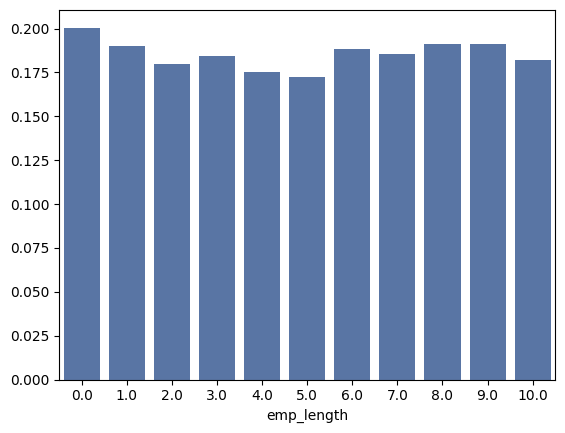

In [27]:
charge_off_rates = (
    dataset
    .groupby('emp_length')['charged_off']
    .value_counts(normalize=True)
    .loc[:,1]
)
sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1)


 Loan status does not appear to vary much with employment length on average, hence it is dropped

In [28]:
dataset.drop(['emp_length'], axis=1, inplace=True)

#### Feature - Subgrade

<AxesSubplot:xlabel='sub_grade'>

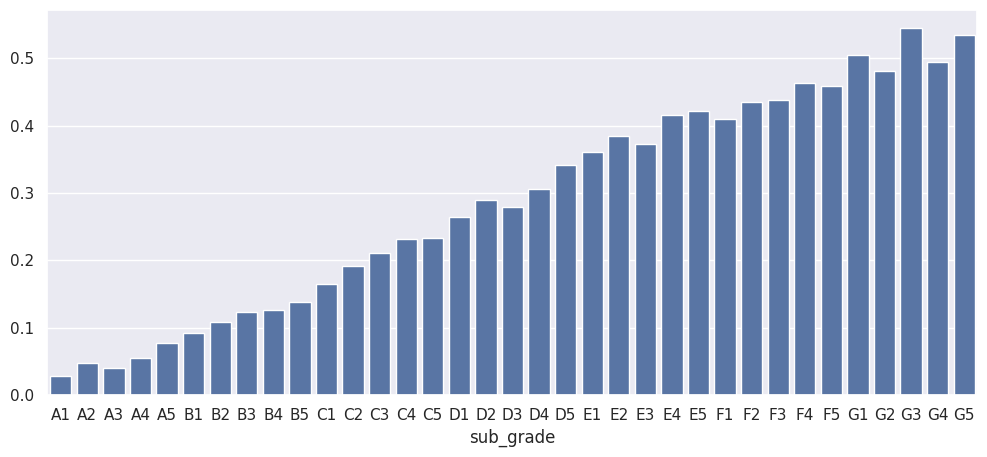

In [29]:
charge_off_rates = (
    dataset
    .groupby('sub_grade')['charged_off']
    .value_counts(normalize=True)
    .loc[:,1]
)
sns.set(rc={'figure.figsize':(12,5)})
sns.barplot(x=charge_off_rates.index, y=charge_off_rates.values, color='#5975A4', saturation=1)


There's a clear trend of higher probability of charge-off as the subgrade worsens.

In [30]:
dataset['earliest_cr_line'] = dataset['earliest_cr_line'].apply(lambda s: int(s[-4:]))


<a id='3.1.2'></a>
### 4.1.2. Analysing the continuous features 

#### Feature : Annual Income

In [31]:
dataset[['annual_inc']].describe()

,annual_inc
count,8.613800e+04
mean,7.384311e+04
std,5.929352e+04
min,4.000000e+03
25%,4.500000e+04
50%,6.247372e+04
75%,9.000000e+04
max,7.500000e+06


Because of the large range of incomes, we should take a log transform of the annual income variable.

In [32]:
dataset['log_annual_inc'] = dataset['annual_inc'].apply(lambda x: np.log10(x + 1))
dataset.drop('annual_inc', axis=1, inplace=True) # Only keep log_annual_inc

#### FICO Scores

In [33]:
dataset[['fico_range_low', 'fico_range_high']].corr()


,fico_range_low,fico_range_high
fico_range_low,1.0,1.0
fico_range_high,1.0,1.0


Given that the correlation between fico low and high is 1 it is preferred to keep only one feature which is average of FICO Scores

In [34]:
dataset['fico_score'] = 0.5 * (dataset['fico_range_low'] + dataset['fico_range_high'])
dataset.drop(['fico_range_high', 'fico_range_low'], axis=1, inplace=True)


In [35]:
dataset['charged_off'].value_counts()


0    69982
1    16156
Name: charged_off, dtype: int64

<a id='3.2'></a>
## 4.2. Encoding Categorical Data

In [36]:
# Filter categorical columns using mask and turn it into a list

categorical_cols = dataset.columns[dataset.dtypes == object].tolist()


In [37]:
categorical_cols

['grade',
 'sub_grade',
 'home_ownership',
 'verification_status',
 'purpose',
 'addr_state',
 'initial_list_status',
 'application_type']

In [38]:
le = LabelEncoder()

# Apply le on categorical feature columns
dataset[categorical_cols] = dataset[categorical_cols].apply(lambda x: le.fit_transform(x))
dataset[categorical_cols].head()


,grade,sub_grade,home_ownership,verification_status,purpose,addr_state,initial_list_status,application_type
0,2,10,3,1,2,40,1,0
1,0,2,1,0,1,4,1,0
2,3,15,3,1,1,21,1,0
4,2,12,3,1,2,3,0,0
5,2,12,3,1,2,26,0,0


In [39]:
dataset.shape


(86138, 29)

<a id='3.4'></a>
## 4.3. Sampling Data

In [40]:
loanstatus_0 = dataset[dataset["charged_off"] == 0]
loanstatus_1 = dataset[dataset["charged_off"] == 1]
subset_of_loanstatus_0 = loanstatus_0.sample(n=5500)
subset_of_loanstatus_1 = loanstatus_1.sample(n=5500)
dataset = pd.concat([subset_of_loanstatus_1, subset_of_loanstatus_0])
dataset = dataset.sample(frac=1).reset_index(drop=True)
print(f"Current shape of dataset : {dataset.shape}")


Current shape of dataset : (11000, 29)


In [41]:
# Filling the NAs with the mean of the column.

dataset.fillna(dataset.mean(), inplace=True)


<a id='4'></a>
# 5. Evaluate Algorithms and Models

<a id='4.1'></a>
## 5.1. Train Test Split

In [42]:
# Split out validation dataset for the end

seed = 7
validation_size = 0.2
Y= dataset['charged_off']
X = dataset.loc[:, dataset.columns != 'charged_off']
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)


In [43]:
# dataset_temp2 = dataset_temp.dropna(axis=0)
# Y_total = dataset_temp2["charged_off"]
# X_total = dataset_temp2.loc[:, dataset.columns != 'charged_off']
# X_dummy, X_validation, Y_dummy, Y_validation = train_test_split(X_total, Y_total, test_size=validation_size)

In [44]:
dataset['charged_off'].value_counts()


0    5500
1    5500
Name: charged_off, dtype: int64

<a id='4.2'></a>
## 5.2. Test Options and Evaluation Metrics


In [45]:
# Test options for classification

num_folds = 10
seed = 7
#scoring = 'accuracy'
#scoring ='precision'
#scoring ='recall'
scoring = 'roc_auc'

<a id='4.3'></a>
## 5.3. Compare Models and Algorithms

### Classification Models

In [46]:
# Spot check the algorithms

models = [
    # Linear models
    ('LR', LogisticRegression()),
    ('LDA', LinearDiscriminantAnalysis()),
    ('KNN', KNeighborsClassifier()),
    ('CART', DecisionTreeClassifier()),
    ('NB', GaussianNB()),
    
    # Neural Network model
    # ('NN', MLPClassifier()), # Too slow
    
    # Ensable Models 
    ('AB', AdaBoostClassifier()),
    ('GBM', GradientBoostingClassifier()),
    ('RF', RandomForestClassifier()),
]


### K-folds cross validation

In [47]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    print(f"{name}: {cv_results.mean():.6f} ({cv_results.std():.6f})")


LR: 0.902983 (0.009458)
LDA: 0.903043 (0.006348)
KNN: 0.826095 (0.009995)
CART: 0.804123 (0.016687)
NB: 0.902271 (0.008360)
AB: 0.930113 (0.006227)
GBM: 0.940908 (0.004829)
RF: 0.934332 (0.004559)


### Algorithm comparison

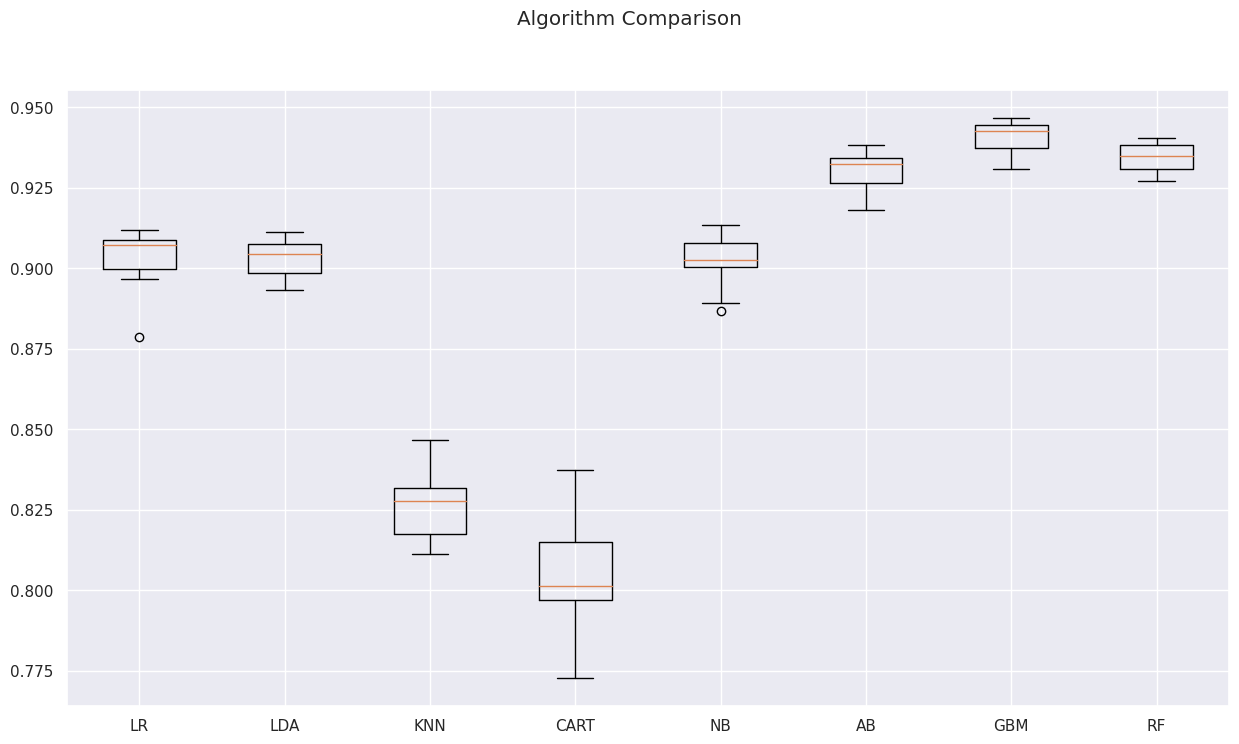

In [48]:
# Compare algorithms

fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15, 8)
pyplot.show()

<a id='5'></a>
# 6. Model Tuning and Grid Search

Given that the GBM is the best model, Grid Search is performed on GBM in this step.

In [52]:
# Grid Search: GradientBoosting Tuning

n_estimators = [20, 180]
max_depth= [3, 5]
param_grid = {'n_estimators': n_estimators, 'max_depth': max_depth,}
model = GradientBoostingClassifier()
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)

# Print Results
print(f"Best: {grid_result.best_score_:.6f} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print(f"#{rank} {mean:.6f} ({stdev:.6f}) with: {param}")


Best: 0.940831 using {'max_depth': 3, 'n_estimators': 180}
#4 0.931141 (0.006319) with: {'max_depth': 3, 'n_estimators': 20}
#1 0.940831 (0.004772) with: {'max_depth': 3, 'n_estimators': 180}
#3 0.936080 (0.005880) with: {'max_depth': 5, 'n_estimators': 20}
#2 0.939239 (0.004446) with: {'max_depth': 5, 'n_estimators': 180}


<a id='6'></a>
# 7. Finalise the Model

Looking at the details above GBM might be worthy of further study, but for now SVM shows a lot of promise as a low complexity and stable model for this problem.

Finalize Model with best parameters found during tuning step.

<a id='6.1'></a>
## 7.1. Results on the Test Dataset

In [53]:
# Prepare model

model = GradientBoostingClassifier(
    max_depth=grid_result.best_params_['max_depth'], 
    n_estimators=grid_result.best_params_['n_estimators'],
)
model.fit(X_train, Y_train)

GradientBoostingClassifier(n_estimators=180)

In [54]:
# Estimate accuracy on validation set
predictions = model.predict(X_validation)


In [55]:
print(accuracy_score(Y_validation, predictions))


0.845


In [56]:
print(confusion_matrix(Y_validation, predictions))


[[ 851  251]
 [  90 1008]]


In [57]:
print(classification_report(Y_validation, predictions))

              precision    recall  f1-score   support

           0       0.90      0.77      0.83      1102
           1       0.80      0.92      0.86      1098

    accuracy                           0.84      2200
   macro avg       0.85      0.85      0.84      2200
weighted avg       0.85      0.84      0.84      2200



<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

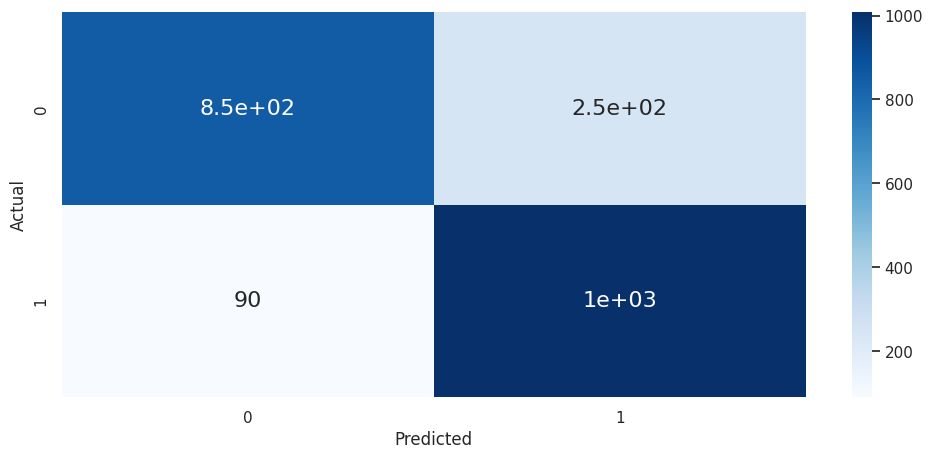

In [58]:
df_cm = pd.DataFrame(
    confusion_matrix(Y_validation, predictions), 
    columns=np.unique(Y_validation), 
    index=np.unique(Y_validation)
)
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
sns.heatmap(df_cm, cmap="Blues", annot=True, annot_kws={"size": 16}) # font sizes

<a id='6.2'></a>
## 7.2. Variable Intuition/Feature Importance
Looking at the details above GBM might be worthy of further study.
Let us look into the Feature Importance of the GBM model

In [59]:
# Use inbuilt class feature_importances of tree based classifiers

print(model.feature_importances_) 

[3.00552565e-03 2.81643484e-03 1.19604638e-01 3.32913569e-02
 2.86459176e-02 1.11708968e-02 2.16277318e-02 1.50897139e-03
 1.89373373e-03 1.46127428e-03 2.81102170e-03 5.42359284e-03
 1.35668491e-03 1.52403290e-03 2.53451640e-03 7.57560592e-05
 7.27229967e-01 0.00000000e+00 1.33246004e-02 3.86748678e-03
 4.11222437e-03 1.42000976e-03 2.98157176e-03 2.02463760e-03
 1.18057700e-03 1.30377419e-03 2.13762213e-03 1.66544297e-03]


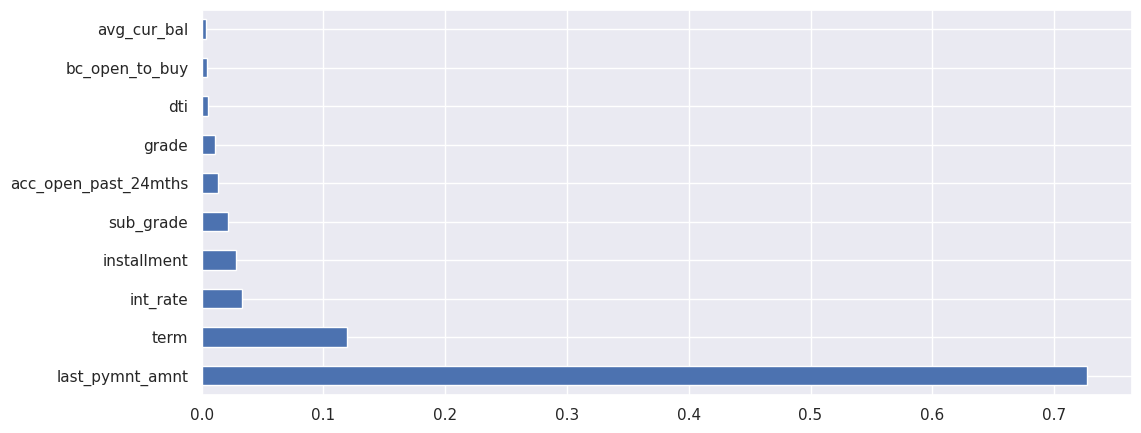

In [60]:
# Plot graph of feature importances for better visualization

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
pyplot.show()


__Conclusion__:

We showed that data preparation is one of the most important steps. We addressed
that by performing feature elimination by using different techniques such as subjec‐
tive judgement, correlation, visualization and the data quality of the feature.
We illustrated that there can be different ways of handling and analyzing the categorical data and converting categorical data into model usable format.

Finally, we analyzed the feature importance and found that results of the case study
are quite intuitive.

